In [1]:
import astropy
from astropy.timeseries import LombScargle
from astropy.coordinates import SkyCoord
from astropy.time import Time, TimeDelta
from astroplan.plots import plot_airmass
from astroplan import Observer, FixedTarget, AirmassConstraint, AtNightConstraint
from astroplan import is_observable
import astropy.units as u
from tqdm import tqdm

np.random.seed(42)

In [2]:
observer = Observer.at_site('lapalma')
coordinates = SkyCoord('00h00m00.0s', '+45d00m00.0s', frame='icrs')
target = FixedTarget(name='target star', coord=coordinates)

In [3]:
survey_start = Time('2021-03-01 12:00:00')
survey_dates = []

Cut down to just the nights in the year when we have a shot at observing:

In [4]:
constraints = [AirmassConstraint(1.5), AtNightConstraint.twilight_nautical()]
for n in tqdm(range(365)):
    if is_observable(constraints, observer, target, 
                         time_range=[survey_start+n*TimeDelta(1.*u.day), 
                                     survey_start+(n+1)*TimeDelta(1.*u.day)]):
        survey_dates.append(survey_start+n*TimeDelta(1.*u.day))

100%|██████████| 365/365 [00:39<00:00,  9.17it/s]


In [5]:
len(survey_dates)

256

In [6]:
t_zeniths = np.zeros(len(survey_dates)) + np.nan
t_zeniths_type = []
t_randomized = np.zeros(len(survey_dates)) + np.nan

dark_horizon = -12. * u.deg # horizon for sunset/sunrise crossing - nautical twilight

for i,t in tqdm(enumerate(survey_dates)):
    t_rise = observer.target_rise_time(t, target, which='nearest', horizon=30.*u.deg)
    t_set = observer.target_set_time(t_rise, target, which='next', horizon=30.*u.deg)
    t_zenith = t_rise + (t_set - t_rise)/2.
    if observer.is_night(t_zenith, horizon=dark_horizon):
        t_zeniths[i] = t_zenith.jd
        t_zeniths_type.append('zenith')
    elif observer.is_night(t_rise, horizon=dark_horizon):
        t_zeniths[i] = observer.sun_rise_time(t_rise, horizon=dark_horizon, which='next').jd
        t_zeniths_type.append('end of night')
    else:
        t_zeniths[i] = observer.sun_set_time(t_rise, horizon=dark_horizon, which='next').jd 
        t_zeniths_type.append('start of night')

    # the following is slow but idk how to be more clever in astroplan:
    for j in range(100):
        t_random = t_zenith + (np.random.random() * 10. - 5.) * TimeDelta(1.*u.hour) # perturb by 5 hours in either direction
        if is_observable(constraints, observer, target, times=t_random):
            t_randomized[i] = t_random.jd
            break


256it [02:09,  1.97it/s]


Sanity checks:

In [7]:
np.sum(np.isfinite(t_randomized))

256

In [8]:
np.sum(np.isfinite(t_zeniths))

256

start of night


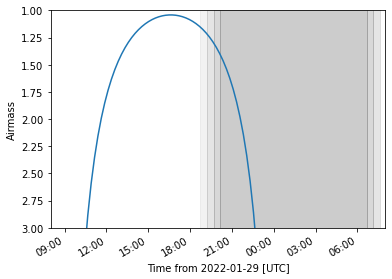

In [9]:
ind = -8
plot_airmass(target, observer, survey_dates[ind]+TimeDelta(8.*u.hour), 
             brightness_shading=True)
print(t_zeniths_type[ind])

In [10]:
Time(t_randomized[ind], format='jd').datetime

datetime.datetime(2022, 1, 29, 20, 28, 34, 514069)

In [11]:
Time(t_zeniths[ind], format='jd').datetime

datetime.datetime(2022, 1, 29, 19, 41, 25, 274135)

In [12]:
t_rise = observer.target_rise_time(survey_dates[ind], target, which='nearest', horizon=30.*u.deg)
t_rise.datetime
observer.is_night(t_rise, horizon=-12.*u.deg)

False

In [13]:
sunset = observer.sun_set_time(t_rise, horizon=-12*u.deg, which='next')
sunset.datetime

datetime.datetime(2022, 1, 29, 19, 41, 25, 274135)

In [14]:
observer.altaz(Time(sunset, format='jd'), target).secz.value

1.300732160717535

In [15]:
airmasses_zenith = np.zeros_like(t_zeniths)
for i,tz in enumerate(t_zeniths):
    try:
        airmasses_zenith[i] = observer.altaz(Time(tz, format='jd'), target).secz.value
    except ValueError:
        continue

In [16]:
airmasses_random = np.zeros_like(t_randomized)
for i,tr in enumerate(t_randomized):
    try:
        airmasses_random[i] = observer.altaz(Time(tr, format='jd'), target).secz.value
    except ValueError:
        continue

In [17]:
airmasses_zenith[ind]

1.300732160717535

In [18]:
np.sum(np.isfinite(t_randomized))

256

#### to check: is the secz() approximation a bad one here?
is that why the airmass seems inconsistent from the plot?

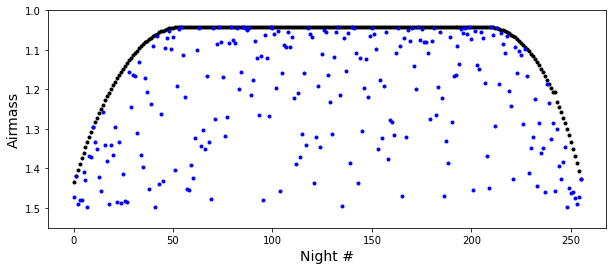

In [42]:
fig, ax = plt.subplots(1,1,figsize=(10,4))
ax.plot(airmasses_zenith, 'k.')
ax.plot(airmasses_random, 'b.')
ax.set_ylim([1.55,1.0])
ax.set_ylabel('Airmass', fontsize=14)
ax.set_xlabel('Night #', fontsize=14);

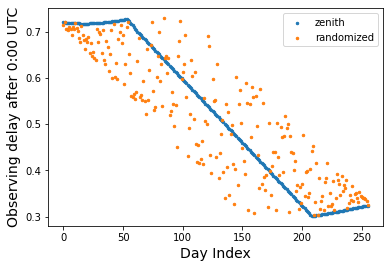

In [20]:
day_inds = np.arange(len(t_zeniths))
plt.scatter(day_inds, t_zeniths % 1.0, label='zenith', s=6)
plt.scatter(day_inds, t_randomized % 1.0, label='randomized', s=6)
plt.xlabel('Day Index', fontsize=14)
plt.ylabel('Observing delay after 0:00 UTC', fontsize=14)
plt.legend();
#plt.plot(day_inds, sunrises, label='sunrise')
#plt.plot(day_inds, sunsets, label='sunset')

In [21]:
t_obs_zenith = t_zeniths[np.isfinite(t_zeniths)]
t_obs_zenith += np.random.normal(0., 30./60./24., len(t_obs_zenith)) # 30-minute perturbation

In [22]:
airmasses = [observer.altaz(Time(to, format='jd'), target).secz.value for to in t_obs_zenith]

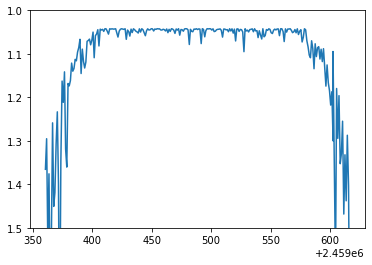

In [23]:
plt.plot(t_obs_zenith,airmasses)
plt.ylim([1.5,1.0]);

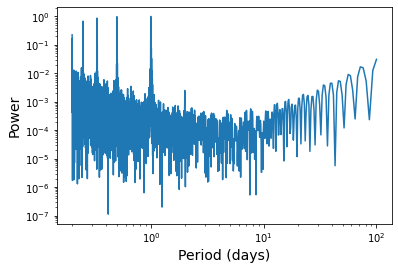

In [24]:
ys_zenith = np.ones_like(t_obs_zenith)/len(t_obs_zenith)# + np.random.normal(0., 1.e-19, len(t_obs_zenith))
frequency, power_zenith = LombScargle(t_obs_zenith, 
                                      ys_zenith, 
                                      fit_mean=False, 
                                      center_data=False).autopower(minimum_frequency=0.01,
                                                   maximum_frequency=5.,
                                                   samples_per_peak=5)
plt.loglog(1./frequency, power_zenith)
plt.xlabel('Period (days)', fontsize=14)
plt.ylabel('Power', fontsize=14);

In [25]:
len(t_obs_zenith)

256

In [26]:
t_obs_randomized = t_randomized[np.isfinite(t_randomized)]
ys_randomized = np.ones_like(t_obs_randomized)/len(t_obs_randomized)

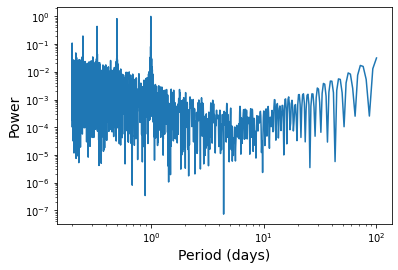

In [27]:
power_randomized = LombScargle(t_obs_randomized, 
                               ys_randomized, fit_mean=False, center_data=False).power(frequency)
plt.loglog(1./frequency, power_randomized)
plt.xlabel('Period (days)', fontsize=14)
plt.ylabel('Power', fontsize=14);
#plt.axvline(0.33, color='C1', alpha=0.7, ls='--');

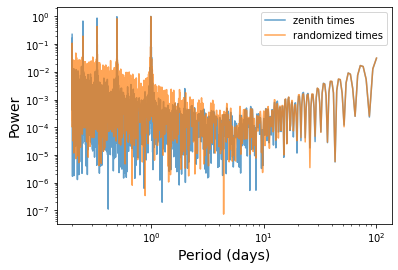

In [28]:
plt.loglog(1./frequency, power_zenith, alpha=0.7, label='zenith times')
plt.loglog(1./frequency, power_randomized, alpha=0.7, label='randomized times')
plt.xlabel('Period (days)', fontsize=14)
plt.ylabel('Power', fontsize=14)
plt.legend();

Hogg sez: there should be no difference in the window function. The reason that these strategies may be different is that under the context of red noise (incl. linear drift or seasonal offsets) that you cannot/do not model, a degeneracy builds between that noise and the sidereal period --> spurious peaks appear. GP with zero mean, low amplitude, long (months) correlation time - prediction that this will lead to false periodogram peaks in the periodic case

Aperiodic observing is better than periodic observing but only if you have noise - but that noise could be below the level of detection.

Add white noise + correlated calibration drifts that are below the level of the detectable noise:
- linear ramp
- GP w/ long correlation time
- summer shutdowns / instrument epochs

In [29]:
# inject white noise
noise_amp = 0.3 # m/s
ys_zenith = np.random.normal(0., noise_amp, len(t_obs_zenith))
yerrs_zenith = np.zeros_like(ys_zenith) + noise_amp
ys_randomized = np.random.normal(0., noise_amp, len(t_obs_randomized))
yerrs_randomized = np.zeros_like(ys_randomized) + noise_amp

In [30]:
def plot_periodograms(ys_zenith, ys_randomized):
    frequency, power_zenith = LombScargle(t_obs_zenith, 
                                      ys_zenith, dy=yerrs_zenith).autopower(minimum_frequency=0.01,
                                                   maximum_frequency=5.,
                                                   samples_per_peak=7)
    power_randomized = LombScargle(t_obs_randomized, 
                               ys_randomized, dy=yerrs_randomized).power(frequency)
    plt.loglog(1./frequency, power_zenith, alpha=0.7, label='zenith times')
    plt.loglog(1./frequency, power_randomized, alpha=0.7, label='randomized times')
    plt.xlabel('Period (days)', fontsize=14)
    plt.ylabel('Power', fontsize=14)
    plt.legend()
    
def plot_timeseries(ys_zenith, ys_randomized):
    fig, ax = plt.subplots(1, 1, figsize=(12,4))
    ax.errorbar(t_obs_zenith, ys_zenith, yerrs_zenith, ls='', 
                fmt='o', alpha=0.7, label='zenith times')
    ax.errorbar(t_obs_randomized, ys_randomized, yerrs_randomized, ls='', 
                fmt='o', alpha=0.7, label='randomized times')
    ax.set_xlabel('Time (days)', fontsize=14)
    ax.set_ylabel('RV (m/s)', fontsize=14)
    ax.legend()
    return fig, ax

#### white noise only:

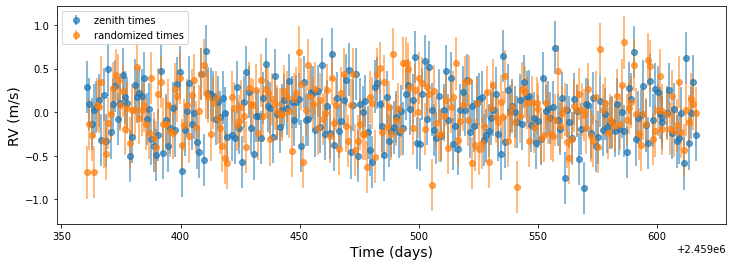

In [31]:
plot_timeseries(ys_zenith, ys_randomized);

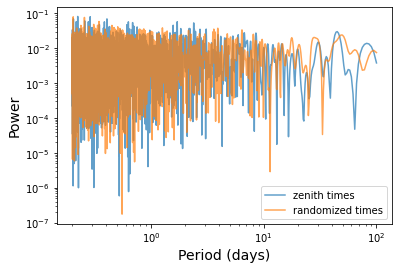

In [32]:
plot_periodograms(ys_zenith, ys_randomized)

#### linear ramp:

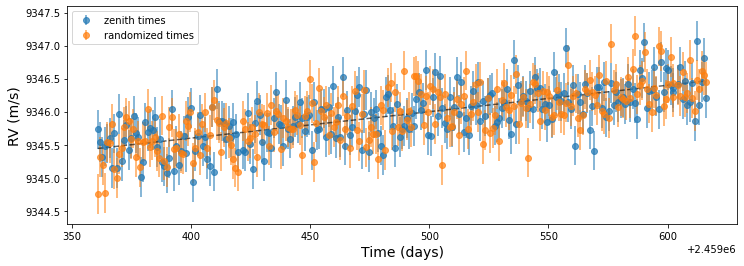

In [33]:
def linear_trend(xs, m=40.e-4, b=-246.*2):
    return m*xs + b

ys_zenith_lin = ys_zenith + linear_trend(t_obs_zenith)
ys_randomized_lin = ys_randomized + linear_trend(t_obs_randomized)

fig,ax = plot_timeseries(ys_zenith_lin, ys_randomized_lin)
ax.plot(t_obs_zenith, linear_trend(t_obs_zenith), ls='--', c='k', alpha=0.6)
plt.show()

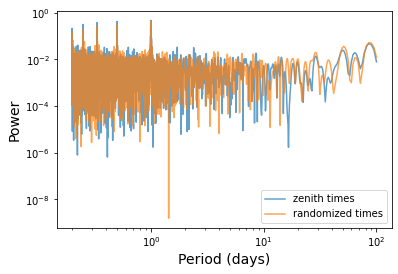

In [34]:
plot_periodograms(ys_zenith_lin, ys_randomized_lin)

#### correlated noise: